## M4_P2_U4_Carlos_Ramirez

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, format_number

import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.master("local").appName("LecturaCSV").getOrCreate()
spark

In [2]:
# Importo el fichero
data = spark.read.options(inferSchema='True',delimiter=';', header=True).csv('StudentPerformance.csv')

In [3]:
data.printSchema()

root
 |-- index: integer (nullable = true)
 |-- race_ethnicity: string (nullable = true)
 |-- parental_education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test_preparation_course: string (nullable = true)
 |-- math_percentage: double (nullable = true)
 |-- reading_percentage: double (nullable = true)
 |-- writing_percentage: double (nullable = true)
 |-- sex: string (nullable = true)



In [4]:
data.show()

+-----+--------------+------------------+------------+-----------------------+---------------+------------------+------------------+---+
|index|race_ethnicity|parental_education|       lunch|test_preparation_course|math_percentage|reading_percentage|writing_percentage|sex|
+-----+--------------+------------------+------------+-----------------------+---------------+------------------+------------------+---+
|    0|       group B| bachelor's degree|    standard|                   none|           0.72|              0.72|              0.74|  F|
|    1|       group C|      some college|    standard|              completed|           0.69|               0.9|              0.88|  F|
|    2|       group B|   master's degree|    standard|                   none|            0.9|              0.95|              0.93|  F|
|    3|       group A|associate's degree|free/reduced|                   none|           0.47|              0.57|              0.44|  M|
|    4|       group C|      some college|

In [5]:
# Muestro las dinstintas categorias de la columna Parental_education
categorias_distintas = data.select('parental_education').distinct()
categorias_distintas.show()

+------------------+
|parental_education|
+------------------+
|  some high school|
|associate's degree|
|       high school|
| bachelor's degree|
|   master's degree|
|      some college|
+------------------+



## 🎓 Análisis de la media por Asignatura en función del Nivel de Educación de los Padres


Las medias más altas en todas las asignaturas generalmente se observan en padres con un nivel educativo más alto, como aquellos con títulos en **bachelor's degree**, **master's degree** o **associate's degree**. Esto sugiere una correlación positiva entre el nivel educativo de los padres y el rendimiento académico de los hijos.

La asignatura con una media más baja es **Match**. Esto se mantiene independientemente del nivel de educación de los Padres, no obstante, y haciendo referencia al punto anterior, las familias con un mayor nivel de educación están obteniendo un mejor rendimiento en **Match** respecto al resto.

Mencionar que en los niveles de **bachelor's degree** y **master's degree**, las medias de **Reading** **Writing** son muy similares y se encuentran entre los más altos de este análisis. Esto sugiere que en este tipo de ambientes familiares se dispone o se dedica tiempo a lectura.

Para finalizar, destacar que, en general, el nivel de estudio **high school** es el que tiene una nota media inferior al resto de niveles de educación parental. Esto sorprende ya que niveles educativos inferiores como **some high school** o **associate's degree** optienen mejores rendimientos.

Es importante señalar que estos son promedios y no reflejan la variabilidad dentro de cada grupo. Además, otros factores no considerados en estos datos pueden influir en el rendimiento académico, como el entorno familiar, la motivación del estudiante, etc.

In [6]:
# Calculo la media de las tres asignaturas. Muestro el resultado en porcetaje
signatureAvg = data.groupBy('parental_education').agg(
    format_number(mean('math_percentage') * 100, 2).alias('Media Math %'),
    format_number(mean('reading_percentage') * 100, 2).alias('Media Reading %'),
    format_number(mean('writing_percentage') * 100, 2).alias('Media Writing %')
)

signatureAvg.show()

+------------------+------------+---------------+---------------+
|parental_education|Media Math %|Media Reading %|Media Writing %|
+------------------+------------+---------------+---------------+
|  some high school|       63.50|          66.94|          64.89|
|associate's degree|       67.88|          70.93|          69.90|
|       high school|       62.14|          64.70|          62.45|
| bachelor's degree|       69.39|          73.00|          73.38|
|   master's degree|       69.75|          75.37|          75.68|
|      some college|       67.13|          69.46|          68.84|
+------------------+------------+---------------+---------------+



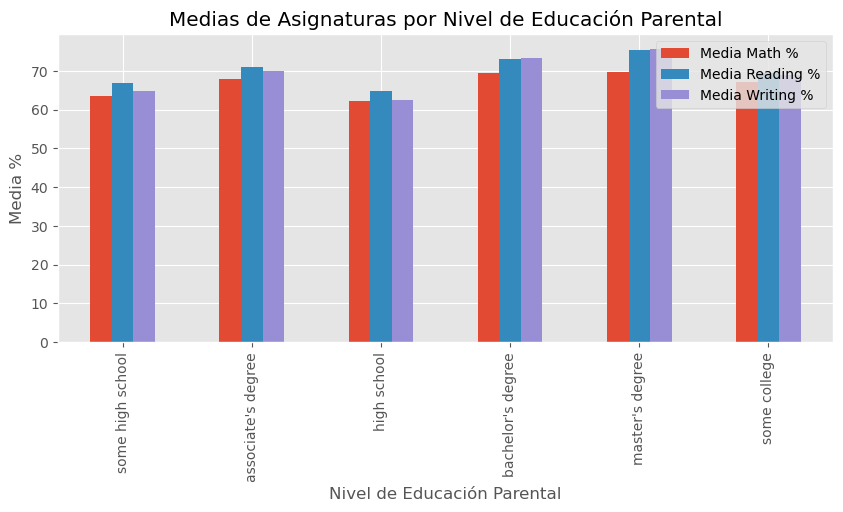

In [7]:
# Convertir DataFrame de PySpark a DataFrame de Pandas
pandas_df = signatureAvg.toPandas()

# Configuración de estilo
plt.style.use('ggplot')

# Convertir las columnas a tipo numérico
pandas_df[['Media Math %', 'Media Reading %', 'Media Writing %']] = pandas_df[['Media Math %', 'Media Reading %', 'Media Writing %']].apply(pd.to_numeric)

# Columnas que tiene el gráfico
columns = ['Media Math %', 'Media Reading %', 'Media Writing %']

# Configuración del gráfico
pandas_df.plot(x='parental_education', y=columns, kind='bar', stacked=False, figsize=(10, 4))

# Etiquetas y Título
plt.xlabel('Nivel de Educación Parental')
plt.ylabel('Media %')
plt.title('Medias de Asignaturas por Nivel de Educación Parental')

plt.show()


## 🎓 Análisis de la média por Asignatura en función de la Etnia


El **Group E** tiene la media total más alta **72.75%**, seguido por **Group D** **69.18%** y **Group C** **67.13%**. Estos grupos parecen tener un rendimiento por encima del promedio en comparación con los demás.

En **Math**, **Group E** lidera con una media del **73.82%**, mientras que **Group A** tiene la media más baja con **61.63%**. Hay una variación significativa entre estos grupos en esta materia.

En Reading y Writing, **Group E** también lidera, pero la diferencia es menos pronunciada en comparación con **Math**.

Existe una tendencia general de rendimiento ascendente de los **grupos A** y **E** en todas las materias y en la media total.
**Group A** tiene las medias más bajas en todas las áreas, mientras que **Group E** tiene las medias más altas.


In [8]:
# Calculo la media de las tres asignaturas agrupadas por Raza
raceAvg = data.groupBy('race_ethnicity').agg(
    format_number(mean('math_percentage') * 100, 2).alias('Media Math %'),
    format_number(mean('reading_percentage') * 100, 2).alias('Media Reading %'),
    format_number(mean('writing_percentage') * 100, 2).alias('Media Writing %')
)

# Media total por sexo
raceAvgTotal = raceAvg.withColumn(
    'Media Total %',
    format_number(((raceAvg['Media Math %'] + raceAvg['Media Reading %'] + raceAvg['Media Writing %']) / 3), 2)
)

raceAvgTotal.show()

+--------------+------------+---------------+---------------+-------------+
|race_ethnicity|Media Math %|Media Reading %|Media Writing %|Media Total %|
+--------------+------------+---------------+---------------+-------------+
|       group B|       63.45|          67.35|          65.60|        65.47|
|       group C|       64.46|          69.10|          67.83|        67.13|
|       group D|       67.36|          70.03|          70.15|        69.18|
|       group A|       61.63|          64.67|          62.67|        62.99|
|       group E|       73.82|          73.03|          71.41|        72.75|
+--------------+------------+---------------+---------------+-------------+



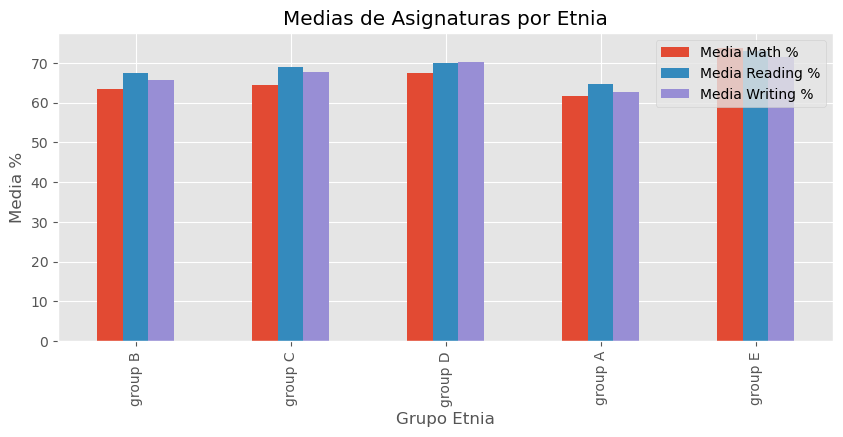

In [9]:
# Convertir DataFrame de PySpark a DataFrame de Pandas
char_df = raceAvg.toPandas()

# Configuración de estilo
plt.style.use('ggplot')

# Convertir las columnas a tipo numérico
char_df[['Media Math %', 'Media Reading %', 'Media Writing %']] = char_df[['Media Math %', 'Media Reading %', 'Media Writing %']].apply(pd.to_numeric)

# Columnas que tiene el gráfico
columns = ['Media Math %', 'Media Reading %', 'Media Writing %']

# Configuración del gráfico
char_df.plot(x='race_ethnicity', y=columns, kind='bar', stacked=False, figsize=(10, 4))

# Etiquetas y Título
plt.xlabel('Grupo Etnia')
plt.ylabel('Media %')
plt.title('Medias de Asignaturas por Etnia')

plt.show()


## 🎓 Análisis de la media por Sexo

Las mujeres **F** muestran una media total del **69,57%**, mientras que los hombres **M** tiene una media total del **65,84%**. Esto sugiere que, en general, las mujeres tienen un rendimiento superior en estas áreas.

En Matemáticas, los hombres **M** superan ligeramente a las mujeres con una media del **68.73%** frente al **63.63%**. Esto podría indicar una brecha de género en esta materia a favor de los hombres.

En **Reading** y **Writing**, las mujeres superan a los hombres significativamente, con medias del **72.61%** y **72.47%** en **Reading** y **Writing**, respectivamente, en comparación con el **65.47%** y **63.31%** de los hombres en estas áreas.

In [10]:
# Calculo la media de las tres asignaturas agrupadas por sexo
sexAvg = data.groupBy('sex').agg(
    format_number(mean('math_percentage') * 100, 2).alias('Media Math %'),
    format_number(mean('reading_percentage') * 100, 2).alias('Media Reading %'),
    format_number(mean('writing_percentage') * 100, 2).alias('Media Writing %')
)
# Media total por sexo
sexAvgTotal = sexAvg.withColumn(
    'Media Total %',
    format_number(((sexAvg['Media Math %'] + sexAvg['Media Reading %'] + sexAvg['Media Writing %']) / 3), 2)
)

sexAvgTotal.show()

+---+------------+---------------+---------------+-------------+
|sex|Media Math %|Media Reading %|Media Writing %|Media Total %|
+---+------------+---------------+---------------+-------------+
|  F|       63.63|          72.61|          72.47|        69.57|
|  M|       68.73|          65.47|          63.31|        65.84|
+---+------------+---------------+---------------+-------------+



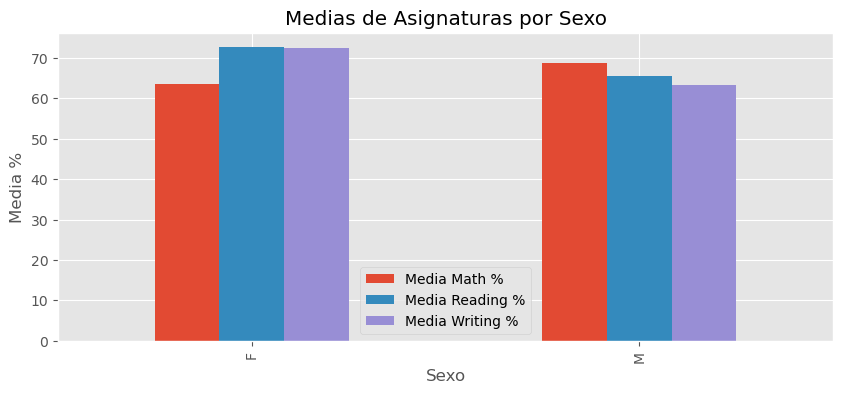

In [11]:
# Convertir DataFrame de PySpark a DataFrame de Pandas
sex_df = sexAvg.toPandas()

# Configuración de estilo
plt.style.use('ggplot')

# Convertir las columnas a tipo numérico
sex_df[['Media Math %', 'Media Reading %', 'Media Writing %']] = sex_df[['Media Math %', 'Media Reading %', 'Media Writing %']].apply(pd.to_numeric)

# Columnas que tiene el gráfico
columns = ['Media Math %', 'Media Reading %', 'Media Writing %']

# Configuración del gráfico
sex_df.plot(x='sex', y=columns, kind='bar', stacked=False, figsize=(10, 4))

# Etiquetas y Título
plt.xlabel('Sexo')
plt.ylabel('Media %')
plt.title('Medias de Asignaturas por Sexo')

plt.show()

## 🎓 Análisis de la media por Tipo de Almuerzo

Los estudiantes que tienen almuerzo **standard** muestran un rendimiento general más alto en comparación con aquellos que tienen almuerzo **free/reduced**. La media total para el almuerzo **standard** es **70.83%**, mientras que para el almuerzo **free/reduced** es **62.20%**.

La brecha entre los dos grupos es evidente en todas las áreas evaluadas (**Math**, **Reading**, **Writing** y **Total**).

Los estudiantes con almuerzo **standard** superan a los estudiantes con almuerzo **free/reduced** en **Math** (**70.03%** frente a **58.92%**), **Reading** (**71.65%** frente a **64.65%**), **Writing** (**70.82%** frente a **63.02%**), y en la media **Total** (**70.83% frente a 62.20%**).

Estos resultados sugieren una asociación entre el tipo de almuerzo (que puede ser indicativo del nivel socioeconómico) y el rendimiento académico.
Los estudiantes que reciben almuerzo **free/reduced** tienden a tener medias más bajas en todas las áreas, lo que puede indicar desafíos socioeconómicos que pueden afectar el rendimiento académico.

In [12]:
# Calculo la media de las tres asignaturas agrupadas por almuerzo
lunchAvg = data.groupBy('lunch').agg(
    format_number(mean('math_percentage') * 100, 2).alias('Media Math %'),
    format_number(mean('reading_percentage') * 100, 2).alias('Media Reading %'),
    format_number(mean('writing_percentage') * 100, 2).alias('Media Writing %')
)
# Media total por sexo
lunchAvgTotal = lunchAvg.withColumn(
    'Media Total %',
    format_number(((lunchAvg['Media Math %'] + lunchAvg['Media Reading %'] + lunchAvg['Media Writing %']) / 3), 2)
)

lunchAvgTotal.show()

+------------+------------+---------------+---------------+-------------+
|       lunch|Media Math %|Media Reading %|Media Writing %|Media Total %|
+------------+------------+---------------+---------------+-------------+
|free/reduced|       58.92|          64.65|          63.02|        62.20|
|    standard|       70.03|          71.65|          70.82|        70.83|
+------------+------------+---------------+---------------+-------------+



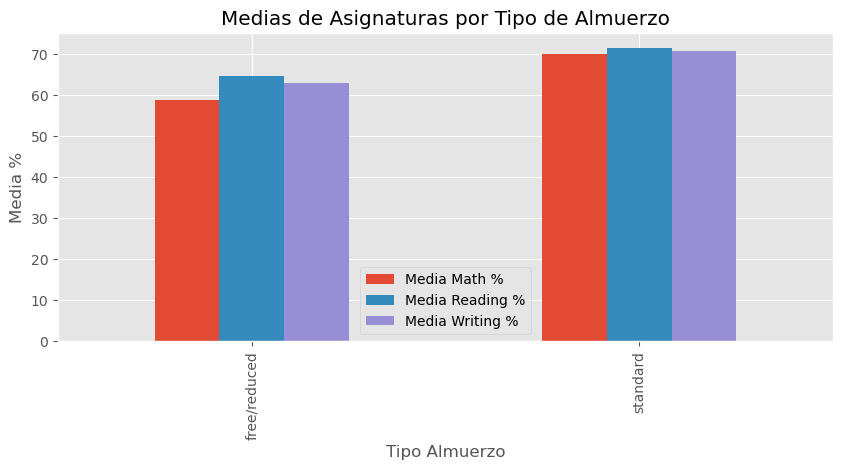

In [13]:
# Convertir DataFrame de PySpark a DataFrame de Pandas
lunch_df = lunchAvg.toPandas()

# Configuración de estilo
plt.style.use('ggplot')

# Convertir las columnas a tipo numérico
lunch_df[['Media Math %', 'Media Reading %', 'Media Writing %']] = lunch_df[['Media Math %', 'Media Reading %', 'Media Writing %']].apply(pd.to_numeric)

# Columnas que tiene el gráfico
columns = ['Media Math %', 'Media Reading %', 'Media Writing %']

# Configuración del gráfico
lunch_df.plot(x='lunch', y=columns, kind='bar', stacked=False, figsize=(10, 4))

# Etiquetas y Título
plt.xlabel('Tipo Almuerzo')
plt.ylabel('Media %')
plt.title('Medias de Asignaturas por Tipo de Almuerzo')

plt.show()

## 🎓 Conclusiones Generales

En general, **las mujeres tienden a tener un rendimiento superior en las áreas de lectura y escritura**, mientras que **los hombres superan ligeramente a las mujeres en matemáticas**. Esto destaca la importancia de abordar las diferencias de género en el enfoque educativo.

Existen variaciones en el rendimiento académico entre diferentes grupos étnicos. El **grupo E muestra consistentemente un rendimiento más alto** en comparación con otros grupos, mientras que el **grupo A tiende a tener medias más bajas**. Estas diferencias pueden requerir intervenciones específicas para garantizar equidad educativa.

Los estudiantes que reciben almuerzo **gratuito/reducido tienen, en promedio, un rendimiento académico más bajo en comparación con aquellos con almuerzo estándar**. Esto destaca la importancia de abordar las disparidades socioeconómicas en el sistema educativo.

Existe una **correlación positiva entre el nivel educativo de los padres y el rendimiento académico de los estudiantes**. Los estudiantes cuyos **padres tienen niveles educativos más altos tienden a tener medias más altas**. Esto resalta la influencia del entorno educativo en el hogar en el rendimiento académico.

Se pueden implementar estrategias educativas específicas para abordar las brechas identificadas y garantizar un acceso equitativo a oportunidades educativas.
La sensibilidad cultural y contextual es esencial al interpretar estos datos, y las intervenciones deben adaptarse a las necesidades específicas de cada grupo.